In [3]:
import numpy as np
import pandas as pd
import datetime, time, multiprocessing, itertools, sys
import matplotlib.pyplot as plt
from COVIDScenarioPipeline.SEIR import seir, setup, results

class MarylandSpatialSetup():
    """
        Setup for Maryland at the county scale.
    """
    def __init__(self):
        folder = 'maryland/'
        self.data = pd.read_csv(f'data/{folder}geodata.csv')
        self.mobility = np.loadtxt(f'data/{folder}mobility.txt')
        self.popnodes = self.data['pop2010'].to_numpy()
        self.nnodes = len(self.data)
        #self.counties_shp = gpd.read_file(f'data/{folder}california-counties-shp/california-counties.shp')
        #self.counties_shp.sort_values('GEOID', inplace=True)
        
class MarylandDelawareSpatialSetup():
    """
        Setup for Maryland at the county scale.
    """
    def __init__(self):
        folder = 'maryland-delaware/'
        self.data = pd.read_csv(f'data/{folder}geodata.csv')
        self.mobility = np.loadtxt(f'data/{folder}mobility.txt')
        self.popnodes = self.data['pop2010'].to_numpy()
        self.nnodes = len(self.data)
        #self.counties_shp = gpd.read_file(f'data/{folder}california-counties-shp/california-counties.shp')
        #self.counties_shp.sort_values('GEOID', inplace=True)

class EastCoastSpatialSetup():
    """
        Setup for East Coast Region at the county scale.
    """
    def __init__(self):
        folder = 'east-coast/'
        self.data = pd.read_csv(f'data/{folder}geodata.csv')
        self.mobility = np.loadtxt(f'data/{folder}mobility.txt')
        self.popnodes = self.data['pop2010'].to_numpy()
        self.nnodes = len(self.data)
        #self.counties_shp = gpd.read_file(f'data/{folder}california-counties-shp/california-counties.shp')
        #self.counties_shp.sort _values('GEOID', inplace=True)
        
        
if __name__ == '__main__':          # For windows thread

    s = setup.Setup(setup_name = 'mid-east-coast_', #'mid-Maryland',
                    spatial_setup = EastCoastSpatialSetup(), #MarylandSpatialSetup(),
                    nsim =  int( 10),
                    ti = datetime.date(2020, 1, 1),
                    tf = datetime.date(2020, 7, 1),
                    interactive = False,
                    write_csv = True,
                    dt = 1/4)


    s.script_npi = 'COVIDScenarioPipeline/data/NPI_Scenario3_Bootsma_1918Influenza.R'

    s.script_import = 'COVIDScenarioPipeline/R/distribute_airport_importations_to_counties.R'

    p = setup.COVID19Parameters(s)
    #p.addNPIfromcsv('data/east-coast/EastCoast_3phase_pc.csv')

    seeding_place = 24510  # Baltimore
    seeding_amount = [0]
    s.buildIC(seeding_places = [int(s.spatset.data[s.spatset.data['geoid'] == seeding_place].id)], 
            seeding_amount = seeding_amount)

    s.set_filter(np.loadtxt('data/east-coast/filter.csv'))
    

 >>> Added Parameters with values: gamma = 1/6, sigma = 1/5.2, r0 between 


In [4]:
seir.onerun_SEIR(s, p, 0)

[1] "Fixed seed importation procedure engaged."


array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.

In [6]:
import time, itertools, multiprocessing
from numba import jit, jitclass, int64, float64
import numpy as np
from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import pandas as pd
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
r_source = robjects.r['source']
r_assign = robjects.r['assign']
r_options = robjects.r['options']
r_options(warn=-1)
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)
    
r_assign('region', 'around_md')
r_source(s.script_import)
importation = robjects.r['county_importations_total']
importation = importation.pivot(index='date', columns='fips_cty', values='importations')
importation.index = pd.to_datetime(importation.index)
importation.columns = pd.to_numeric(importation.columns)
importation = importation.reindex(sorted(importation.columns), axis=1)
for col in s.spatset.data['geoid']:
    if col not in importation.columns:
        importation[col] = 0

idx = pd.date_range(s.ti, s.tf)
importation = importation.reindex(idx, fill_value=0)


[1] "Fixed seed importation procedure engaged."


In [7]:
importation

fips_cty,10001,10003,10005,24001,24003,24005,24009,24011,24013,24015,...,51790,51800,51810,51820,51830,51840,11001,34007,42017,42101
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2020-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2020-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [24]:

importation.index = pd.to_datetime(importation.index)
for col in s.spatset.data['geoid']:
    if col not in importation.columns:
        importation[col] = 0

In [26]:

idx = pd.date_range(s.ti, s.tf)
importation = importation.reindex(idx, fill_value=0)

TypeError: '<' not supported between instances of 'float' and 'str'

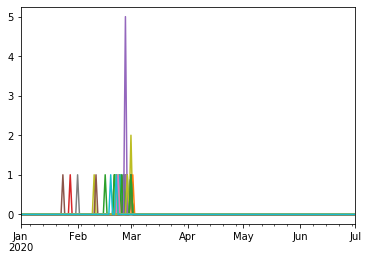

In [7]:
importation.plot(legend=False)

In [8]:
filter = np.loadtxt('data/east-coast/filter.csv')

In [10]:
filter = pd.DataFrame(filter, index = pd.date_range(s.ti, s.tf))

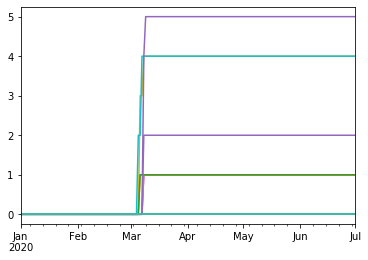

In [12]:
filter.plot(legend=False)

In [4]:
import time, itertools, multiprocessing
from numba import jit, jitclass, int64, float64
import numpy as np
from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import pandas as pd
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
r_source = robjects.r['source']
r_assign = robjects.r['assign']
r_options = robjects.r['options']
r_options(warn=-1)
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)

In [5]:
    r_assign('region', 'around_md')
    r_source('COVIDScenarioPipeline/R/distribute_airport_importations_to_counties.R')
    importation = robjects.r['county_importations_total']
    importation = importation.pivot(index='date', columns='fips_cty', values='importations')
    importation.index = pd.to_datetime(importation.index)
    for col in s.spatset.data['geoid']:
        if col not in importation.columns:
            importation[col] = 0
    importation = importation.reindex(sorted(importation.columns), axis=1)
    idx = pd.date_range(s.ti, s.tf)
    importation = importation.reindex(idx, fill_value=0)

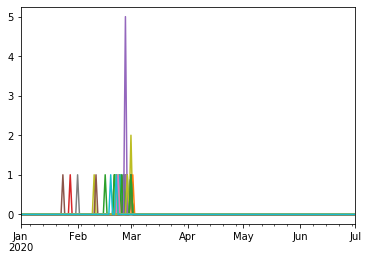

In [14]:
importation.plot(legend=False)

In [30]:
importation.to_numpy()[23]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

fips_cty,10001.0,10003.0,10005.0,11001.0,24001.0,24003.0,24005.0,24009.0,24011.0,24013.0,...,51750.0,51760.0,51770.0,51775.0,51790.0,51800.0,51810.0,51820.0,51830.0,51840.0
2020-01-01,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-28,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-29,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-30,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(733, 24)

In [56]:
p.betas[:,i,:].shape

(733, 24)

SyntaxError: invalid syntax (<ipython-input-5-f2da568ef78a>, line 1)